In [1]:
#Time series data of HD50896 from TESS - 1st part
import os, sys

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import matplotlib.ticker as ticker

import numpy as np

import astropy
from astropy.io import fits
from astropy.io import ascii
import astropy.units as u
# from astropy.utils.data import get_pkg_data_filename   #time-series extraction tool
# from astropy.timeseries import TimeSeries

import lightkurve as lk    #good time-series library

import pandas as pd 

from scipy.optimize import curve_fit
from scipy.optimize import minimize

import emcee
import corner
from dynesty import NestedSampler
from dynesty import plotting as dyplot

In [2]:
#read from manually downloaded data from MAST
hd_lc1 = lk.read('tess2018349182500-s0006-0000000078959225-0126-s_lc.fits')
hd_lc1

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
object,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1468.275658949996,3.8153544e+05,6.8091309e+01,3.5933100e-03,173388,1798.22381,1148.35156,3.6825331e+05,6.5543350e+01,4.0732793e+03,1.0987913e+01,3.8153544e+05,6.8091309e+01,1000000000,nan,nan,nan,nan,1798.22381,1.9521288e-04,1148.35156,1.8575993e-04,-2.6038872e-02,-1.6257873e-02
1468.2770478816171,3.8129062e+05,6.8121017e+01,3.5933533e-03,173389,1798.22815,1148.35002,3.6847259e+05,6.5571953e+01,4.0845789e+03,1.1031659e+01,3.8129062e+05,6.8121017e+01,0,nan,nan,nan,nan,1798.22815,1.9523820e-04,1148.35002,1.8567441e-04,-2.1792805e-02,-1.8228658e-02
1468.2784368130044,3.8144528e+05,6.8116653e+01,3.5933964e-03,173390,1798.22852,1148.35194,3.6853875e+05,6.5567749e+01,4.0675962e+03,1.0985822e+01,3.8144528e+05,6.8116653e+01,0,nan,nan,nan,nan,1798.22852,1.9528455e-04,1148.35194,1.8564636e-04,-2.0513691e-02,-1.6220167e-02
1468.2798257443924,3.8147722e+05,6.8121689e+01,3.5934395e-03,173391,1798.22481,1148.34661,3.6859269e+05,6.5572594e+01,4.0734509e+03,1.0990284e+01,3.8147722e+05,6.8121689e+01,0,nan,nan,nan,nan,1798.22481,1.9530924e-04,1148.34661,1.8572700e-04,-2.3422165e-02,-2.2260994e-02
1468.2812146757808,3.8174784e+05,6.8143333e+01,3.5934825e-03,173392,1798.23023,1148.35230,3.6885275e+05,6.5593430e+01,4.0748550e+03,1.0989996e+01,3.8174784e+05,6.8143333e+01,0,nan,nan,nan,nan,1798.23023,1.9510891e-04,1148.35230,1.8568533e-04,-1.9279534e-02,-1.5657596e-02
1468.2826036074016,3.8170931e+05,6.8146454e+01,3.5935258e-03,173393,1798.23077,1148.34807,3.6886953e+05,6.5596443e+01,4.0810027e+03,1.0989873e+01,3.8170931e+05,6.8146454e+01,0,nan,nan,nan,nan,1798.23077,1.9518004e-04,1148.34807,1.8565520e-04,-1.8429298e-02,-2.0638591e-02
1468.2839925387896,3.8201750e+05,6.8169357e+01,3.5935689e-03,173394,1798.22736,1148.35035,3.6913397e+05,6.5618477e+01,4.0789397e+03,1.0992376e+01,3.8201750e+05,6.8169357e+01,0,nan,nan,nan,nan,1798.22736,1.9500872e-04,1148.35035,1.8555147e-04,-2.1759626e-02,-1.7861202e-02
1468.2853814701773,3.8202097e+05,6.8171112e+01,3.5936120e-03,173395,1798.23105,1148.35060,3.6913994e+05,6.5620171e+01,4.0569138e+03,1.1001123e+01,3.8202097e+05,6.8171112e+01,0,nan,nan,nan,nan,1798.23105,1.9511316e-04,1148.35060,1.8551630e-04,-1.8175492e-02,-1.7037949e-02


In [3]:
hd_lc1.filename

'tess2018349182500-s0006-0000000078959225-0126-s_lc.fits'

Trying to obtain the PDCSAP flux from the time series. However, a little bit of context first.

- **SAP light curve** is summing together the brightness of pixels that fall within an aperture set by any of these survey missions - referred to as the **optimal aperture**, though, still subject to systematic artifacts of the respective mission.

- **PDCSAP light curve** has more treatment than SAP. The PDCSAP pipeline attempts to remove systematic artifacts while keeping planetary transits intact (made with planet detection intentions)

Text(0.5, 1.0, 'PDCSAP Light Curve of HD 050896 - ts1')

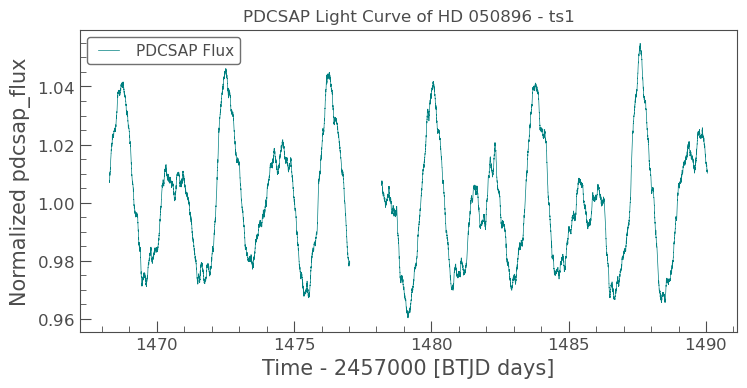

In [4]:
ax = hd_lc1.plot(column='pdcsap_flux', label='PDCSAP Flux', color='teal', normalize=True)    #PDCSAP flux
ax.set_title('PDCSAP Light Curve of HD 050896 - ts1')
#hd_lc1.plot(column='sap_flux', label='SAP Flux', color='r', normalize=True, ax=ax);    #SAP flux
#ax.set_xlim(1470, 1471)
#ax.set_ylim(1.005, 1.01)

In [5]:
#timeseries's metadata
hd_lc1.meta

{'INHERIT': True,
 'EXTNAME': 'PRIMARY',
 'EXTVER': 1,
 'SIMDATA': False,
 'TELESCOP': 'TESS',
 'INSTRUME': 'TESS Photometer',
 'OBJECT': 'TIC 78959225',
 'TICID': 78959225,
 'RADESYS': 'ICRS',
 'RA_OBJ': 103.554350353116,
 'DEC_OBJ': -23.9283389773658,
 'EQUINOX': 2000.0,
 'EXPOSURE': 17.246064015583,
 'TIMEREF': 'SOLARSYSTEM',
 'TASSIGN': 'SPACECRAFT',
 'TIMESYS': 'TDB',
 'BJDREFI': 2457000,
 'BJDREFF': 0.0,
 'TIMEUNIT': 'd',
 'TELAPSE': 21.775333353009,
 'LIVETIME': 17.246064015583347,
 'TSTART': 1468.273575668771,
 'TSTOP': 1490.048908790299,
 'DATE-OBS': '2018-12-15T18:32:47.754',
 'DATE-END': '2019-01-06T13:09:16.535',
 'DEADC': 0.792,
 'TIMEPIXR': 0.5,
 'TIERRELA': 1.16e-05,
 'INT_TIME': 1.98,
 'READTIME': 0.02,
 'FRAMETIM': 2.0,
 'NUM_FRM': 60,
 'TIMEDEL': 0.001388888888888889,
 'BACKAPP': True,
 'DEADAPP': True,
 'VIGNAPP': True,
 'GAINA': 5.21999979019165,
 'GAINB': 5.28000020980835,
 'GAINC': 5.320000171661377,
 'GAIND': 5.21999979019165,
 'READNOIA': 10.074599266052246,
 'R

### Lomb-Scargle Periodogram of HD 050896

In [6]:
#Lomb-Scargle Periodogram - normalised to parts per million
#freq = np.linspace(0.1, 100, 100)
pg_hd_lc1 = hd_lc1.normalize(unit='ppm').to_periodogram(frequency = np.linspace(0.1,100,500))    #plot with less points
pg_hd_lc1

LombScarglePeriodogram(ID: TIC 78959225)

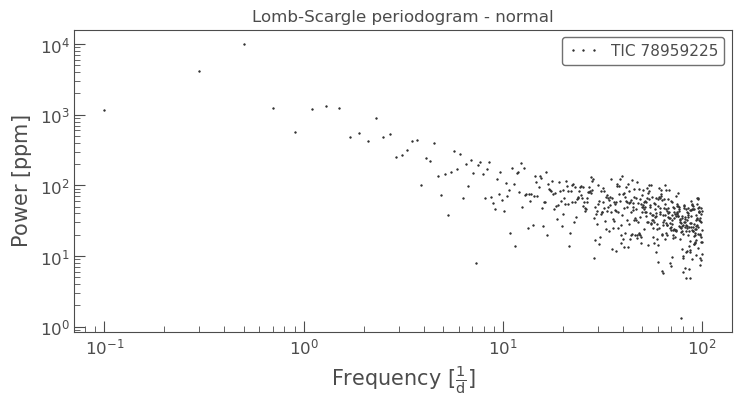

In [7]:
#Inspecting the periodogram
ax = pg_hd_lc1.plot(view='frequency', scale='log', linestyle='None', marker='+')
#ax.set_xlim(0,20)
ax.set_title('Lomb-Scargle periodogram - normal')
plt.savefig('LS_lc1_log_noline')

In [8]:
pg_hd_lc1.period_at_max_power   #period at max power

<Quantity 1.99839808 d>

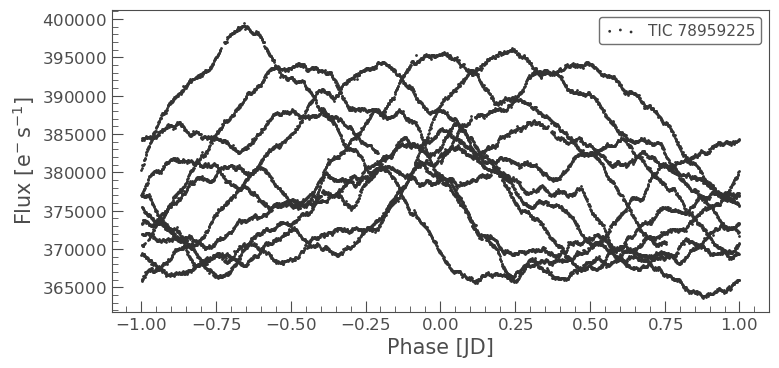

In [9]:
#Folding light curve using max power period
hd_lc1.fold(period=pg_hd_lc1.period_at_max_power).scatter()

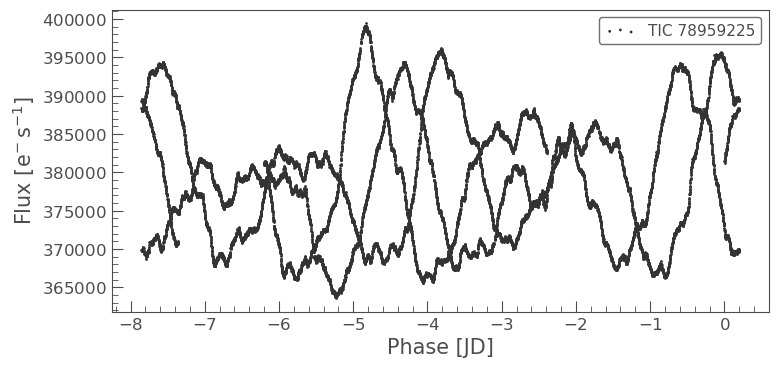

In [10]:
#Testing with folding params & then remaking periodogram
hd_lc1.fold(period=4.03*pg_hd_lc1.period_at_max_power, wrap_phase=0.2).scatter()

Hmm... Is this the best this star can do in terms of time series??? Ask Ian. 

1.8791674056716203 d


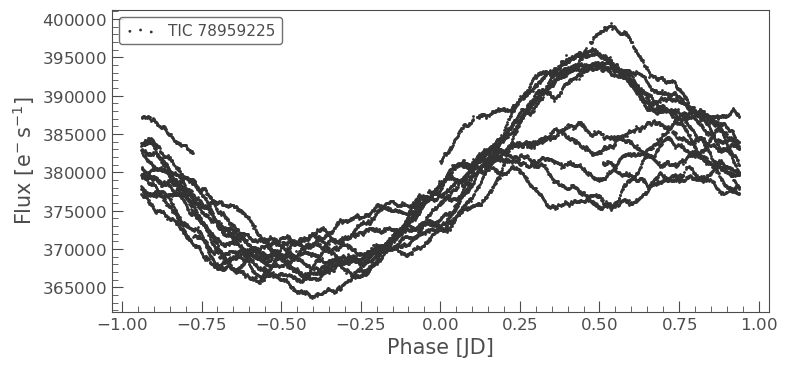

In [11]:
#Increasing oversampling frequency = 10
pg_hd_lc1 = hd_lc1.normalize(unit='ppm').to_periodogram(minimum_period=1.6*u.day, maximum_period=2*u.day, oversample_factor=10)
print(pg_hd_lc1.period_at_max_power)
hd_lc1.fold(period=pg_hd_lc1.period_at_max_power).scatter()

Text(0.5, 1.0, 'Edited LS periodogram - oversample_f = 10; min_p = 1.6 days, max_p = 2 days')

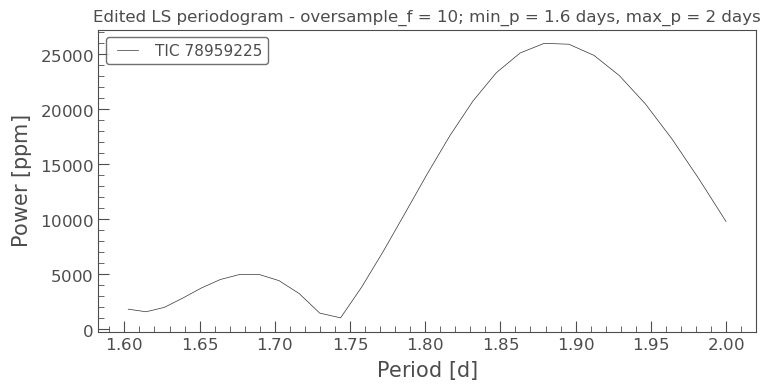

In [12]:
#Inspecting LS post-modification
ax = pg_hd_lc1.plot(view='period', scale='linear')
#ax.set_xlim(0,20)
ax.set_title('Edited LS periodogram - oversample_f = 10; min_p = 1.6 days, max_p = 2 days')

In [13]:
#Writing relevant light curves into ascii files
hd_lc1.write("hd050896_lc1.txt", format="ascii.fixed_width", overwrite=True)

Attempt to fit Lomb-Scargle using MCMC algorithm and amplitude spectrum function from Bowman et al. (2019),

$$\alpha(\nu) = \frac{\alpha_0}{1+(\frac{\nu}{\nu_c})^\gamma} + C_w$$

where $\alpha_0$ represents the amplitude at a frequency of zero, $\gamma$ is the logarithmic amplitude gradient,
$\nu_c$ is the characteristic frequency, which is the inverse of the characteristic timescale, $\tau$, of
stochastic variability present in the light curve such that $\nu_c = (2\pi\tau)^{-1}$, and $C_w$ is a frequency-independent
(white) noise term

Text(0.5, 1.0, 'Lomb-Scargle periodogram - normal')

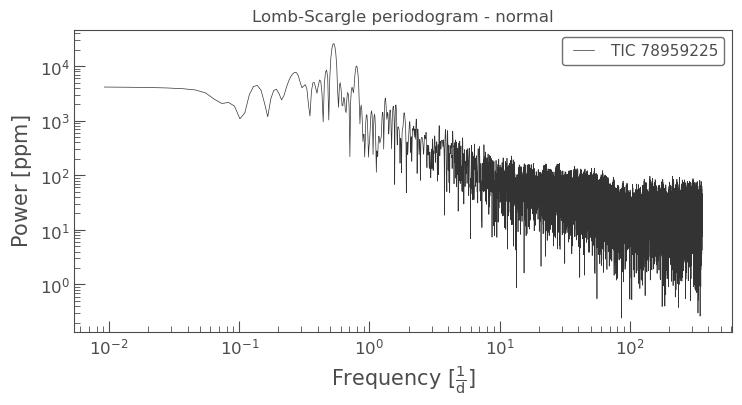

In [14]:
#Re-draw LS
pg_hd_lc1 = hd_lc1.normalize(unit='ppm').to_periodogram()
x = getattr(pg_hd_lc1, 'frequency')   #frequency array
y = getattr(pg_hd_lc1, 'power')       #power (ppm) array

x = [float(i/(1*x.unit)) for i in x]        #converting to scalars
y = [float(j/(1*y.unit)) for j in y]

ax = pg_hd_lc1.plot(view='frequency', scale='log')
ax.set_title('Lomb-Scargle periodogram - normal')

#print (x)

In [15]:
#Defining likelihood, flat prior and combined to probability
def log_likelihood(theta, x, y):   #a1 = v_c, a2 = gamma, a3 = C_w // x = \nu
    a0, a1, a2, a3, log_f = theta
    model = (a0/(1+(x/a1)**a2)) + a3
    sigma2 = model ** 2 * np.exp(2 * log_f)    #sigma is 0, not s_n
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

#define flat prior
def log_prior(theta):
    a0, a1, a2, a3, log_f = theta
    if 10**3 < a0 < 10**4 and 10**-2 < a1 < 10**2 and 0 < a2 < 6 and 10**-6 < a3 < 10**-1 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y)

In [16]:
#Define 'true' values of a0, a1, a2, a3
a0_true = 10**2
a1_true = 10
a2_true = 3
a3_true = 10**-5
f_true = 2

#Optimising likelihood
nll = lambda *args: -log_likelihood(*args)
initial = np.array([a0_true, a1_true, a2_true, a3_true, np.log(f_true)])
soln = minimize(nll, initial, args=(x, y))    #minimize used here
a0_ml, a1_ml, a2_ml, a3_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("a0 = {0:.3f}".format(a0_ml))
print("a1 = {0:.3f}".format(a1_ml))
print("a2 = {0:.3f}".format(a2_ml))
print("a3 = {0:.3f}".format(a3_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

<ipython-input-15-8cc6a10be651>:4: RuntimeWarning: overflow encountered in power
  model = (a0/(1+(x/a1)**a2)) + a3
<ipython-input-15-8cc6a10be651>:5: RuntimeWarning: overflow encountered in exp
  sigma2 = model ** 2 * np.exp(2 * log_f)    #sigma is 0, not s_n
C:\Users\MKH\Documents\Anaconda\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
<ipython-input-15-8cc6a10be651>:4: RuntimeWarning: overflow encountered in power
  model = (a0/(1+(x/a1)**a2)) + a3
<ipython-input-15-8cc6a10be651>:5: RuntimeWarning: overflow encountered in exp
  sigma2 = model ** 2 * np.exp(2 * log_f)    #sigma is 0, not s_n
<ipython-input-15-8cc6a10be651>:4: RuntimeWarning: overflow encountered in power
  model = (a0/(1+(x/a1)**a2)) + a3
<ipython-input-15-8cc6a10be651>:4: RuntimeWarning: overflow encountered in power
  model = (a0/(1+(x/a1)**a2)) + a3
<ipython-input-15-8cc6a10be651>:4: RuntimeWarning: invalid value encountered in power
  mod

Maximum likelihood estimates:
a0 = -444683.407
a1 = -1156382.414
a2 = -542484.152
a3 = -4636.939
f = 0.000


<ipython-input-15-8cc6a10be651>:4: RuntimeWarning: invalid value encountered in power
  model = (a0/(1+(x/a1)**a2)) + a3


In [17]:
#MCMC comes into play
pos = soln.x + 1e-4 * np.random.randn(500, 5)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y)
)
sampler.run_mcmc(pos, 10000, progress=True);

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]C:\Users\MKH\Documents\Anaconda\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:58<00:00, 171.21it/s]


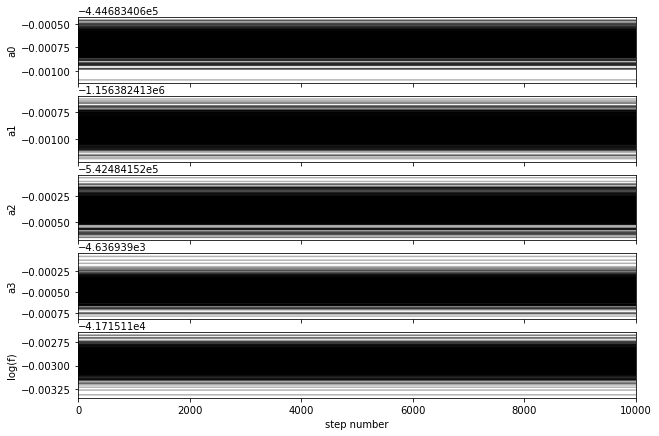

In [18]:
#Inspecting what the sampler has done
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a0", "a1", "a2", "a3", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [19]:
tau = sampler.get_autocorr_time()
print(tau)

C:\Users\MKH\Documents\Anaconda\lib\site-packages\emcee\autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
C:\Users\MKH\Documents\Anaconda\lib\site-packages\emcee\autocorr.py:43: RuntimeWarning: invalid value encountered in less
  m = np.arange(len(taus)) < c * taus


[nan nan nan nan nan]


C:\Users\MKH\Documents\Anaconda\lib\site-packages\emcee\autocorr.py:101: RuntimeWarning: invalid value encountered in greater
  flag = tol * tau_est > n_t


In [20]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(330000, 5)


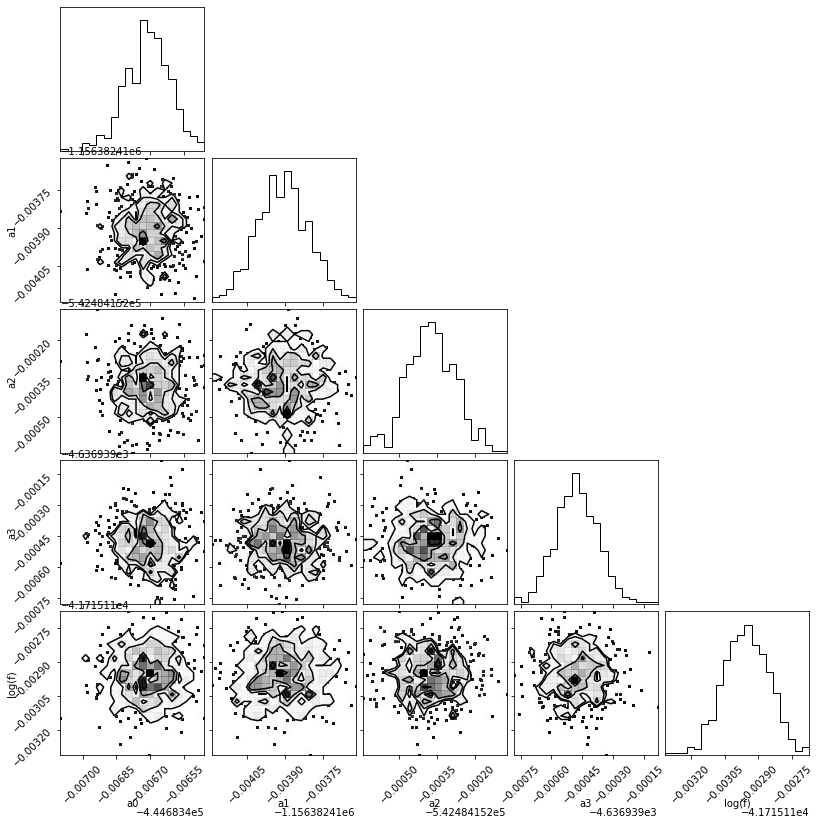

In [21]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[a0_true, a1_true, a2_true, a3_true, f_true]
);

<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered

<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered

<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered

<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered

<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered

<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered

<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered

<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered

<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered

<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered

<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered

<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered

<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered

<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered

<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered

<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered

<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
<ipython-input-22-d62ad89798d6>:4: RuntimeWarning: invalid value encountered

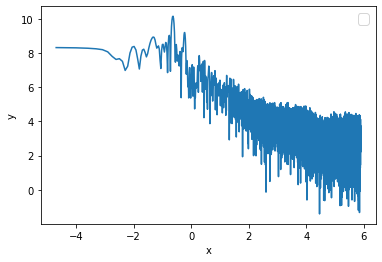

In [22]:
inds = np.random.randint(len(flat_samples), size=1000)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x, np.log(np.dot(np.vander(x, 2), sample[:2])), alpha=0.1)
#plt.errorbar(x, y, fmt=".k", capsize=0)
#plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
#plt.plot(x, a0_true/(1+(x/a1_true)**a2_true)) + a3_true)
plt.plot(np.log(x), np.log(y))
plt.legend(fontsize=14)
#plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");